# CITS4403 Flavour Network Project Part 4
# Flavours of the World: How Russian Cuisine Fits Within a Network of Recipes, Ingredients and Compounds from Around the Globe
Authors: Alden Bong (22255844), Dylan Carpenter (21982288), Luke Joshua Carpenter (22110274)

Creating suitable visualization for the networks and assessing the frequency of individual ingredients and categories.

In [1]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np
import json
from math import log

NUM_NODES = 9000
ALPHA = 1e-20

### Generating a networkx network from the input csv

In [2]:
def draw_Network(file, compoundMap = None):
    G=nx.Graph()
    ingredientList = []
    node_sizes = {}
    
    # From csv, create network nodes and edges
    for row in file:
        if row[0] not in ingredientList:
            ingredientList.append(row[0])
            G.add_node(row[0])
            node_sizes.update({row[0]:int(row[2])})
        else:
            node_sizes[row[0]] = node_sizes.get(row[0], 0) + int(row[2])
            
        if row[1] not in ingredientList:
            ingredientList.append(row[1])
            G.add_node(row[1])
            node_sizes.update({row[1]:int(row[2])})
        else:
            node_sizes[row[1]] = node_sizes.get(row[1], 0) + int(row[2])
            
        if compoundMap is None:  # Using Prevalance Weighting
            weight = int(row[2])
        else:
            weight = len(set(compoundMap[row[0]]).intersection(compoundMap[row[1]]))
            
        G.add_edge(row[0], row[1], weight=weight)
    return G, node_sizes


with open('data/no-overlap/noOverlapIngredientPairings.csv') as csvfile:
    file = csv.reader(csvfile)
    G, node_sizes = draw_Network(file)

### Identifying and storing the nodes after the supplementary papers filters are applied

In [3]:
# Get base b to the power of exponent e, using fast exponentiation
def exp(base,ex):
    if (ex == 0):
        return 1
    if (ex == 1):
        return base
    root = exp(base, ex // 2)
    return root*root*exp(base, ex % 2)

In [4]:
# Determine which edges should be kept
def trim_network(G, alpha, colourMap):

    trimmed_edge_list = []
    
    for node in G.nodes():
        # Initialise Needed Variables
        sum_weight = 0
        max_weight = 0
        degree = G.degree(node)
        
        # Get sum_weight and max_weight
        for neighbor in G.neighbors(node): # Neighbors of the node
            weight = G.get_edge_data(node,neighbor)['weight']
            sum_weight += weight
            max_weight = max(max_weight, weight)
            
        # Determine Which Edges To Keep; Edges are coloured by the node that keeps them
        for neighbor in G.neighbors(node): # Neighbors of the node
            edge = (node,neighbor)
            weight = G.get_edge_data(node,neighbor)['weight']
            # Keep Largest Weighted Edges
            if weight == max_weight:
                trimmed_edge_list.append(edge)
                G.get_edge_data(node, neighbor)["edge_color"] = colourMap[node]
                continue
            # Keep Statistically Significant Weighted Edges
            if exp(1 - weight/max_weight, degree-1) < alpha:
                trimmed_edge_list.append(edge)
                G.get_edge_data(node, neighbor)["edge_color"] = colourMap[node]
    
    # Return Subgraph with Only Kept Edges
    return G.edge_subgraph(trimmed_edge_list)

In [5]:
# Keep At Most Number of Nodes Specified by num_nodes
most_prevalent = [node for node, weight in sorted(node_sizes.items(), key=lambda item: item[1], reverse=True)][:NUM_NODES]
node_sizes = dict([(node, weight) for node, weight in sorted(node_sizes.items(),key=lambda item: item[1], reverse=True)][:NUM_NODES])

with open("data/fullColourMap.json") as colourFile:
    colourMap = json.load(colourFile)
    G = trim_network(G, ALPHA, colourMap)

### Drawing the backbone network to screen

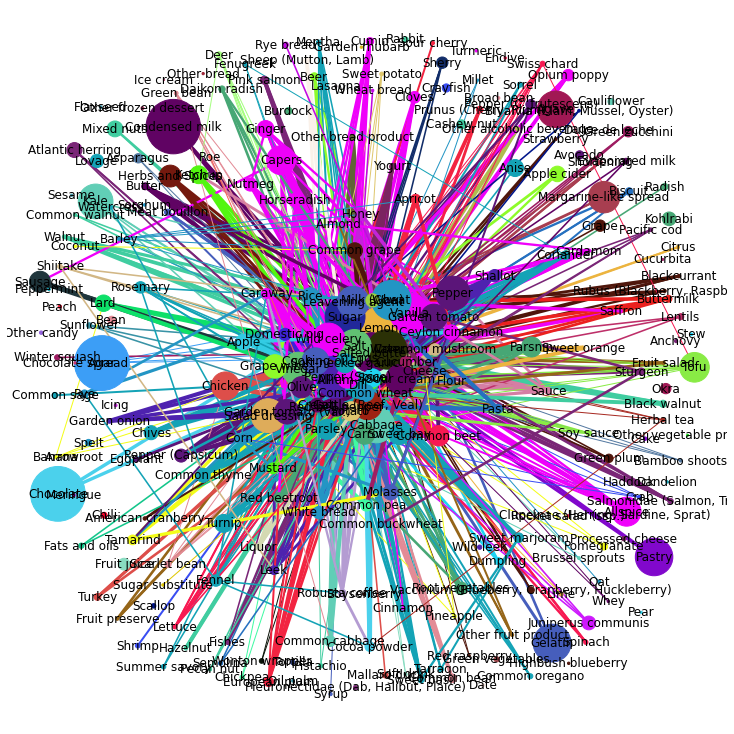

In [6]:
def draw_primary_network(G, node_sizes, colourMap):
    # Scale node sizes according to mean size within network and some fixed value 0.05
    plt.figure(1,figsize=(10,10))
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    edge_color = [G[u][v]['edge_color'] for u,v in edges]
    node_color = [colourMap[node] for node in G.nodes]

    scaled_weights = []
    for xx in weights:
        scaled_weights.append(str(log(xx)/log(2)))

    # Tuning node and edge parameters like size and color
    pos = nx.spring_layout(G,k=1, iterations=20)
    scaled_nodes = {xx: yy / total for total in (mean(node_sizes.values())*0.004,) for xx, yy in node_sizes.items()}
    nx.draw(G, pos, node_color=node_color, edge_color=edge_color,
            node_size=list(scaled_nodes.values()),with_labels = True,width=scaled_weights)
    plt.draw()
draw_primary_network(G, node_sizes,colourMap)

### Drawing a supplementary network using only recipes Pelmeni and Cabbage Pie

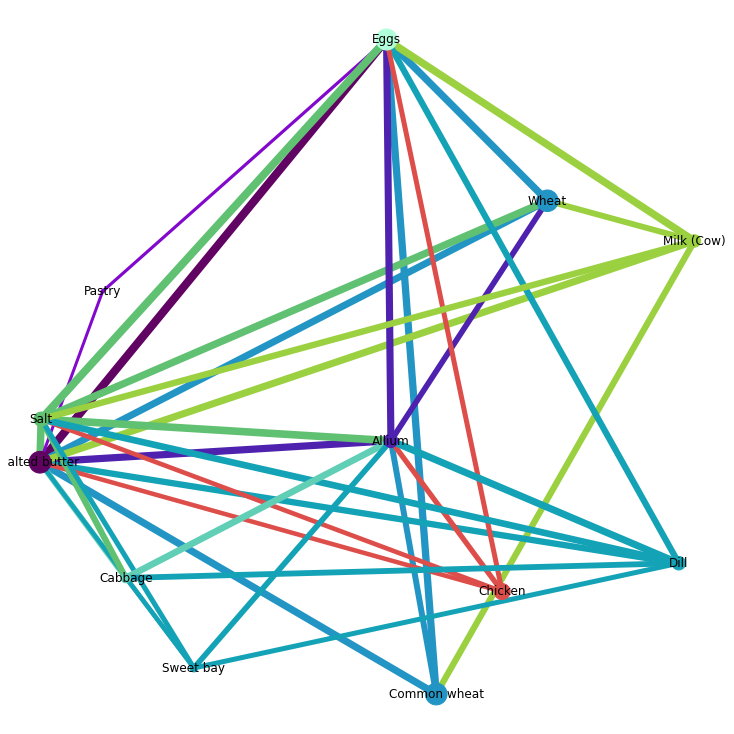

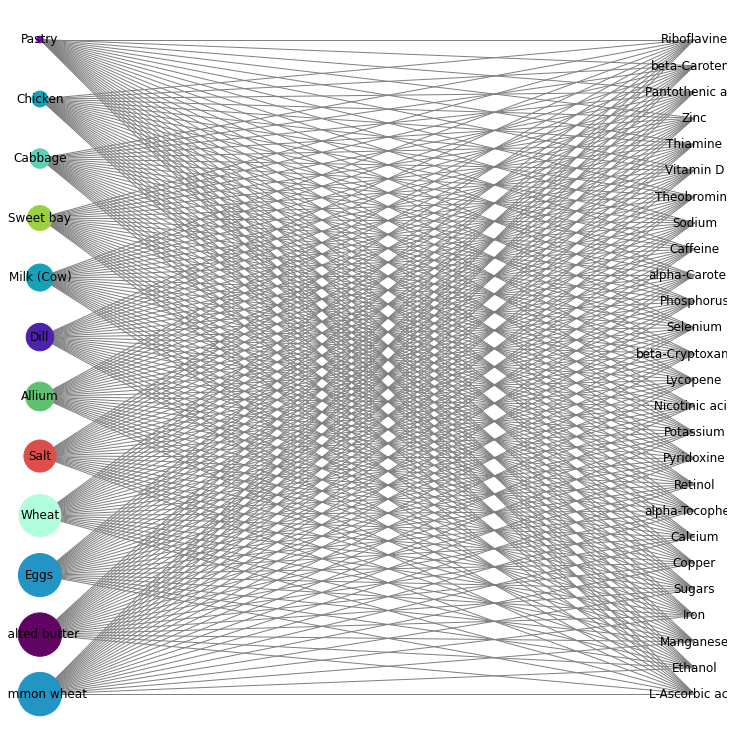

In [7]:
def draw_subgraph(G,colourMap,node_sizes):
    # Get subgraph from 1b in barabasi paper
    plt.figure(4,figsize=(10,10))
    ingrSet = set(["Allium", "Chicken", "Common wheat","Eggs","Milk (Cow)", "Salt", "Sweet bay","Wheat","Cabbage","Dill","Eggs","Pastry","Salt","Salted butter"])
    H = G.subgraph(ingrSet)
    edges = H.edges()
    weights = [H[uu][vv]['weight'] for uu,vv in edges]
    edge_color = [H[uu][vv]['edge_color'] for uu,vv in edges]
    node_color = [colourMap[node] for node in H.nodes]
    scaled_weights = []
    for xx in weights:
        scaled_weights.append(str(log(xx)/log(2)))
    node_sizes = {ingr: freq for ingr, freq in node_sizes.items() if ingr in ingrSet}
        
    # Tuning node and edge parameters like size and color
    pos = nx.spring_layout(G,k=5, iterations=20)
    scaled_nodes = {xx: yy / total for total in (mean(node_sizes.values())*0.004,) for xx, yy in node_sizes.items()}
    nx.draw(H,pos,with_labels = True,node_color=node_color, edge_color=edge_color, node_size=list(scaled_nodes.values()),width=scaled_weights)
    plt.draw()
    
    ## Draw Compound Mapping
    plt.figure(5,figsize=(10,10))
    # Load Compound Map
    with open('data/compounds/compounds.json') as compoundsFile:
        compoundMap = json.load(compoundsFile)
    # Initialise Graph
    ingrCompoundBipartiteNetwork = nx.Graph()
    # Create Nodes
    compounds = set()
    for ingr in ingrSet:
        for compound in compoundMap[ingr]:
            if len(compounds) > 25:
                break
            if compound not in compounds:
                node_color.append("#000000")
                compounds.add(compound)
                node_sizes[compound] = 0
    ingrCompoundBipartiteNetwork.add_nodes_from(ingrSet, bipartite=0)
    ingrCompoundBipartiteNetwork.add_nodes_from(compounds, bipartite=1)
    scaled_nodes = {xx: yy / total for total in (sum(node_sizes.values())*0.001/len(ingrSet),) for xx, yy in node_sizes.items()}
    # Create Edges
    edge_list = [(ingr, compound) for compound in compoundMap[ingr] if compound in compounds for ingr in ingrSet]
    ingrCompoundBipartiteNetwork.add_edges_from(edge_list)
    # Draw Network
    pos = nx.drawing.layout.bipartite_layout(ingrCompoundBipartiteNetwork.nodes(), ingrSet)
    nx.draw(ingrCompoundBipartiteNetwork,pos, with_labels = True,node_color=node_color,\
            node_size=list(scaled_nodes.values()), edge_color="grey")

draw_subgraph(G,colourMap,node_sizes)

### Drawing a histogram containing ingredient frequencies,
### Note: Power Law!

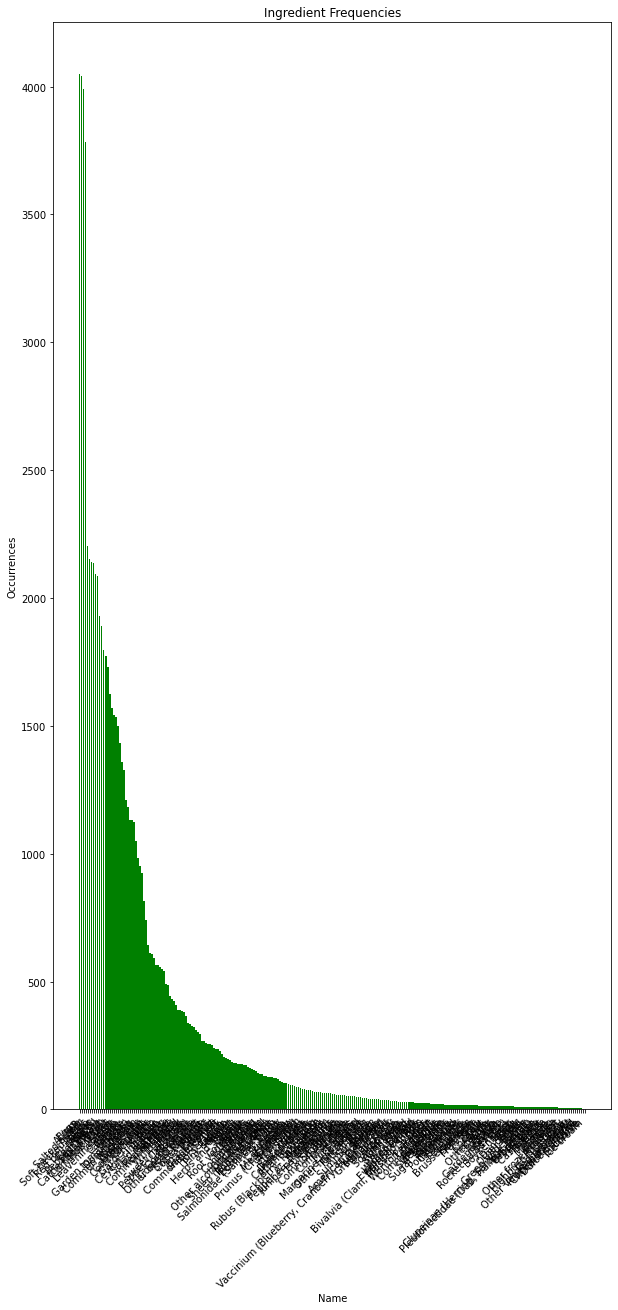

In [8]:
def hist_nodes(title, tuple_list):
    
    plt.figure(2,figsize=(10,20))
    plt.title(title)
    plt.xlabel("Name")
    plt.ylabel("Occurrences")
    plt.bar([xx[0] for xx in tuple_list], [xx[1] for xx in tuple_list], color='g')
    plt.xticks(rotation=45,ha='right')

tuple_list = list(node_sizes.items())
tuple_list.sort(key=lambda tup: tup[1], reverse = True)

hist_nodes("Ingredient Frequencies", tuple_list)


### Drawing a log log scatter plot of the same ingredient frequency data

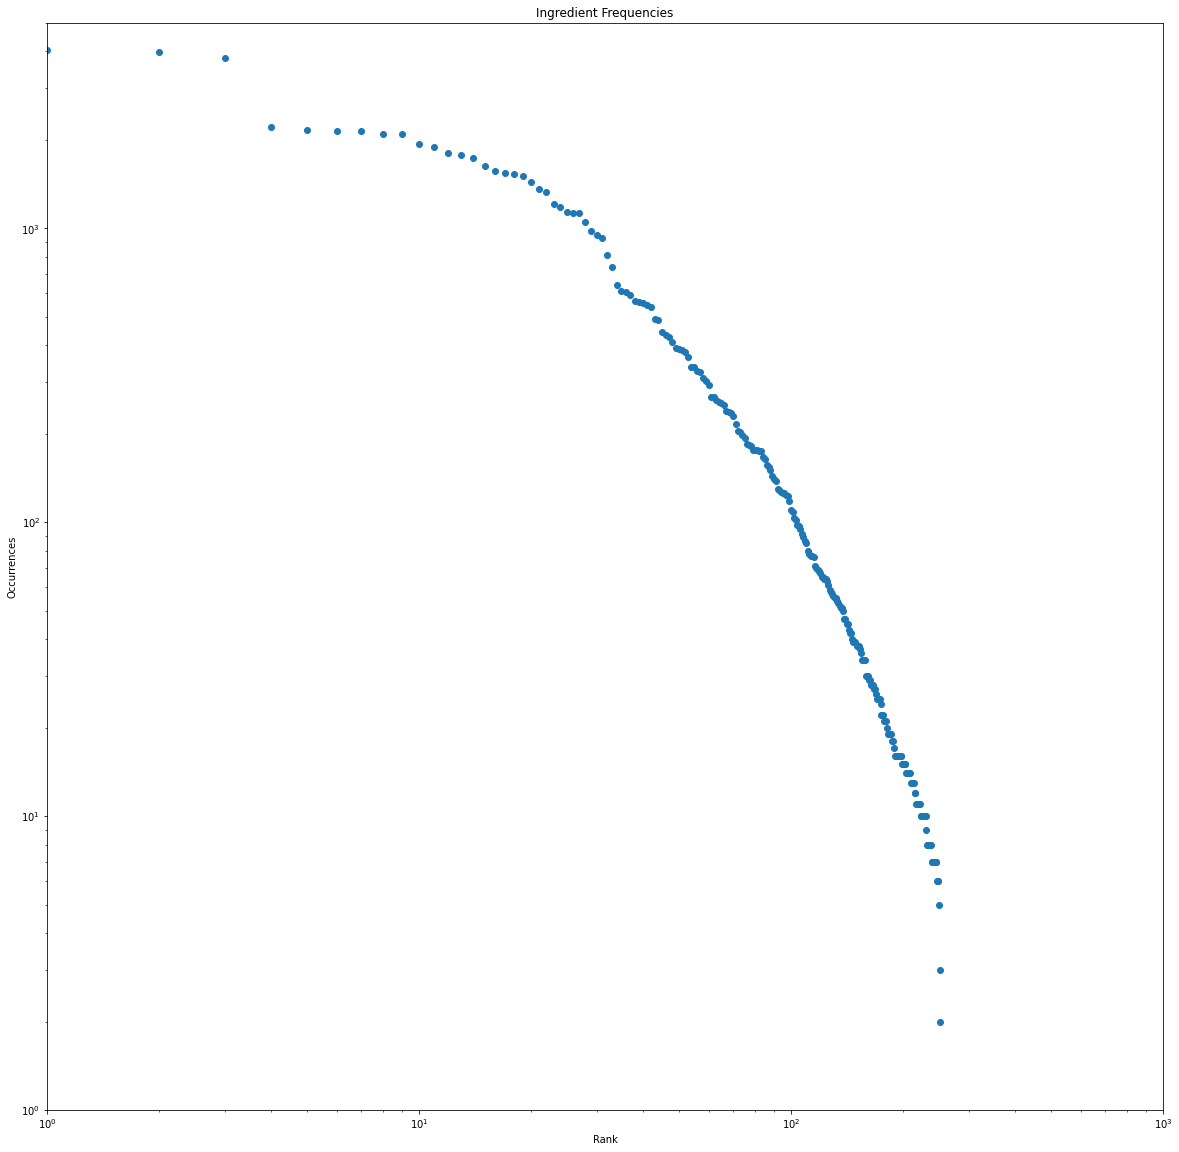

In [9]:
def scatter_plot_nodes(title, tuple_list):
    plt.figure(3,figsize=(20,20))
    plt.title(title)
    plt.xlabel("Rank")
    plt.ylabel("Occurrences")
    ax = plt.gca()
    ax.scatter([rank for rank,xx in enumerate(tuple_list)], [xx[1] for xx in tuple_list])
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xlim(1,1000)
    plt.ylim(1,5000)
scatter_plot_nodes("Ingredient Frequencies", tuple_list)

## Repeating above steps for category data

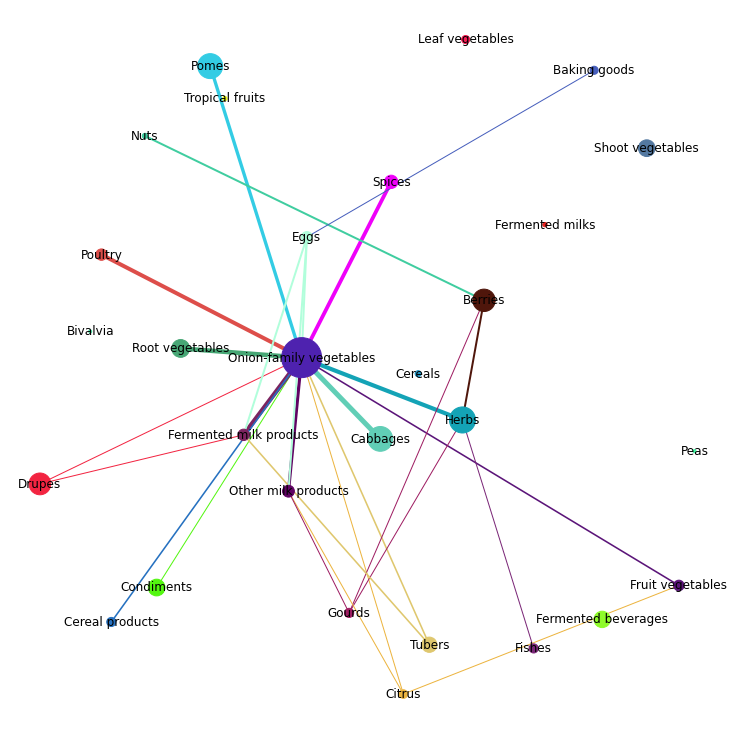

In [10]:
with open('data/category_csv2.csv') as csvfile:
    file = csv.reader(csvfile)
    
    G, node_sizes = draw_Network(file)
    G = trim_network(G, ALPHA, colourMap)
    
    # Keep At Most Number of Nodes Specified by num_nodes
    most_prevalent = [node for node, weight in sorted(node_sizes.items(), key=lambda item: item[1], reverse=True)][:NUM_NODES]
    node_sizes = dict([(node, weight) for node, weight in sorted(node_sizes.items(),key=lambda item: item[1], reverse=True)][:NUM_NODES])
    draw_primary_network(G, node_sizes,colourMap)
    

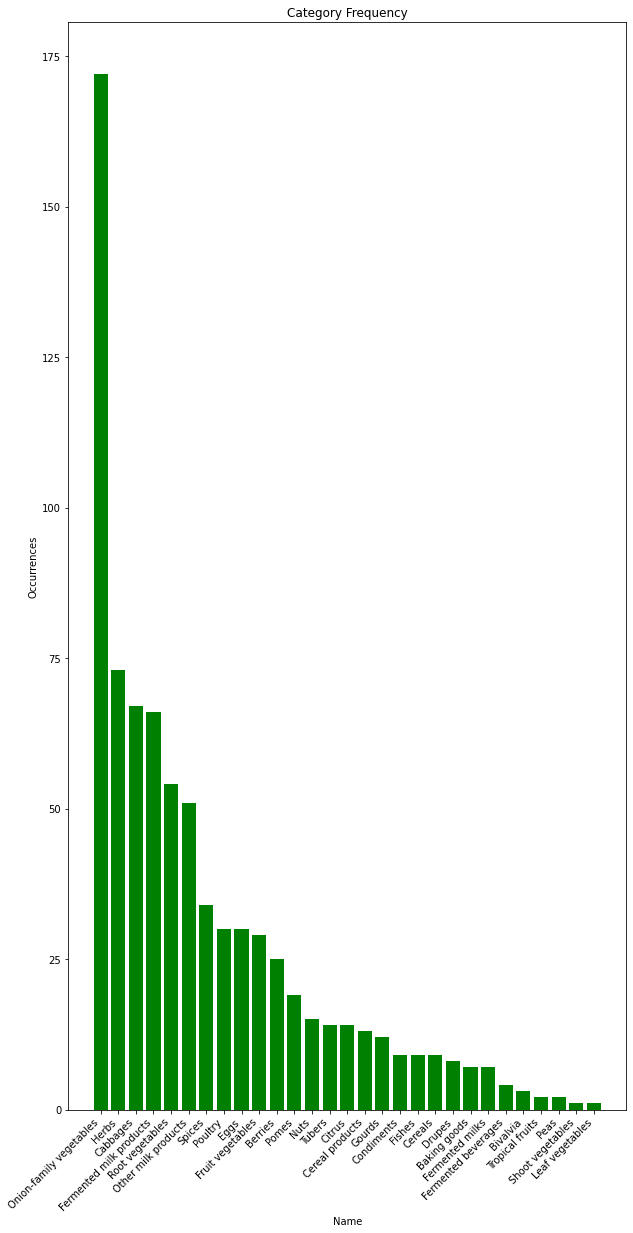

In [11]:
tuple_list = list(node_sizes.items())
tuple_list.sort(key=lambda tup: tup[1], reverse = True)

hist_nodes("Category Frequency", tuple_list = list(node_sizes.items()))
tuple_list.sort(key=lambda tup: tup[1], reverse = True)

hist_nodes("Category Frequency", tuple_list)

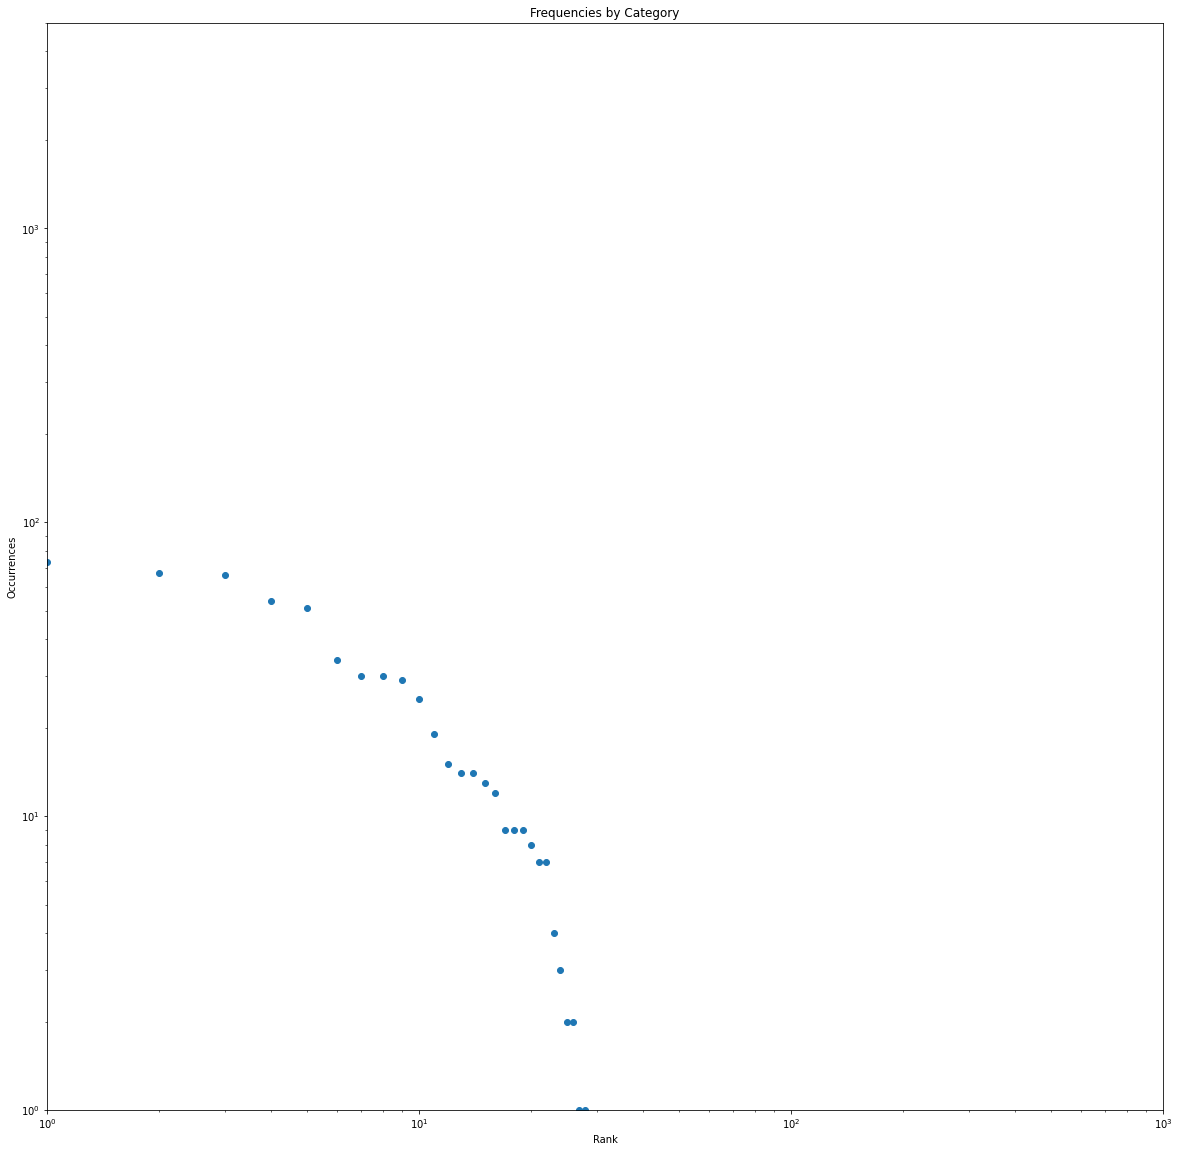

In [12]:
scatter_plot_nodes("Frequencies by Category", tuple_list)

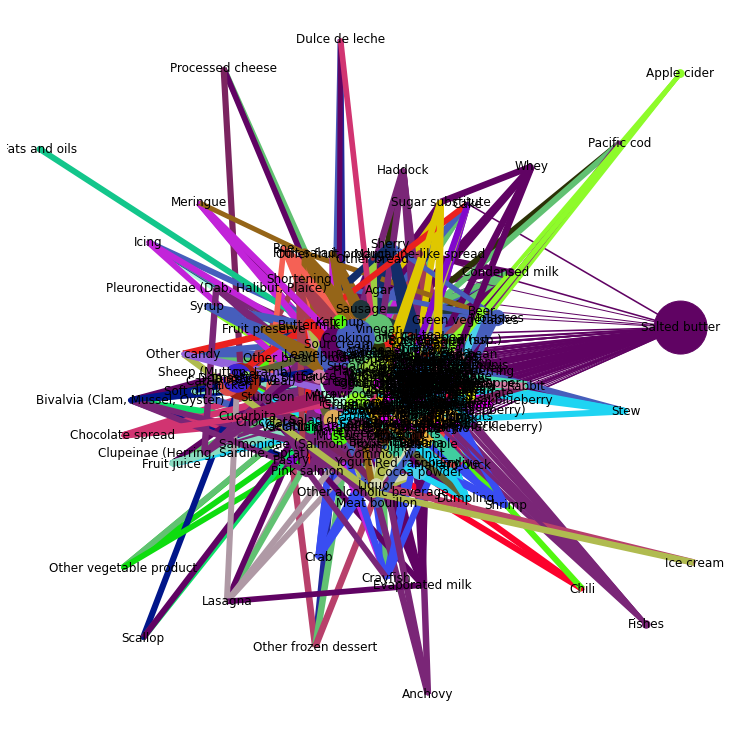

In [13]:
## Draw Compound Weighting Backbone Network
# Load Compound Map
with open('data/compounds/compounds.json') as compoundsFile:
    compoundMap = json.load(compoundsFile)
with open('data/no-overlap/noOverlapIngredientPairings.csv') as csvfile:
    file = csv.reader(csvfile)
    G, node_sizes = draw_Network(file, compoundMap)
with open("data/fullColourMap.json") as colourFile:
    colourMap = json.load(colourFile)
    G = trim_network(G, ALPHA, colourMap)
draw_primary_network(G, node_sizes,colourMap)

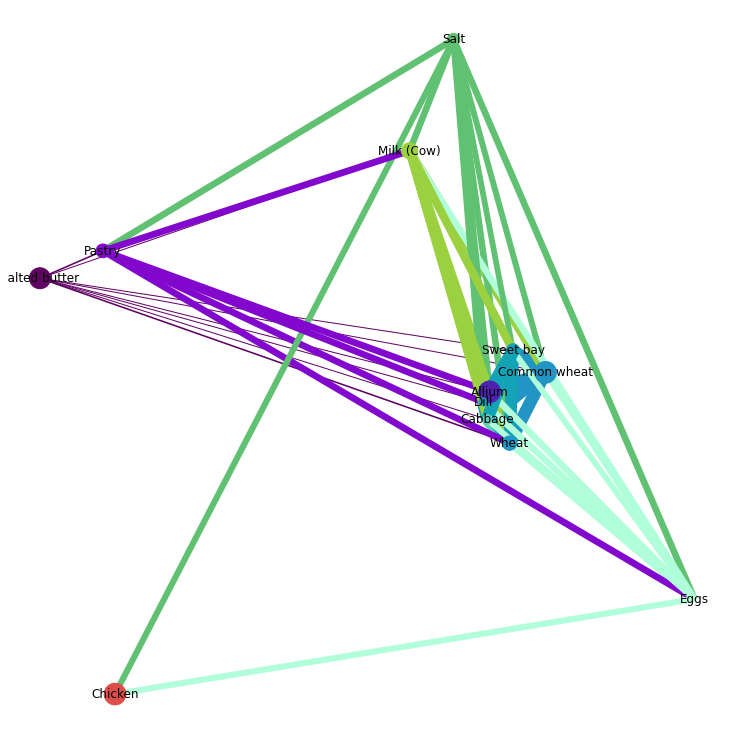

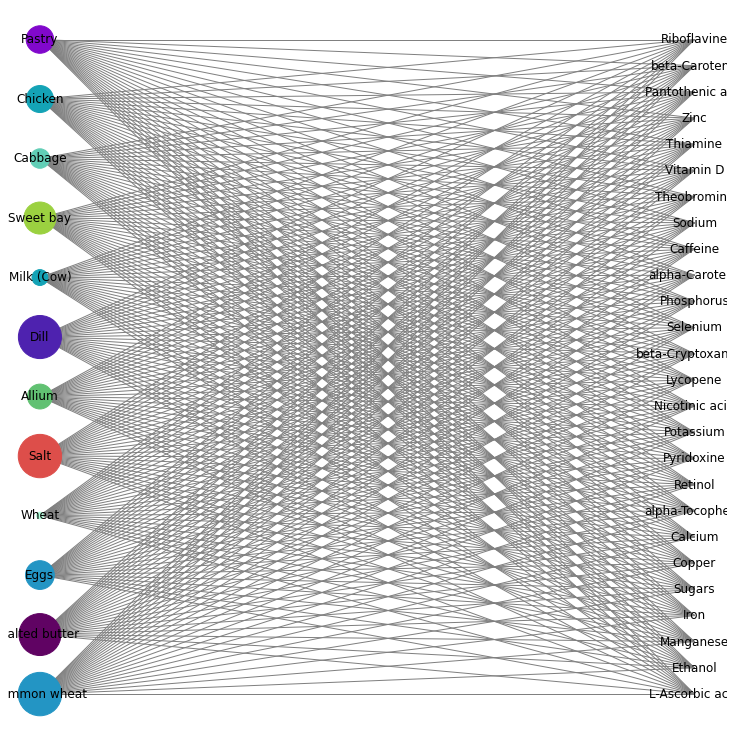

In [14]:
## Draw Compound Weighting Example
draw_subgraph(G,colourMap,node_sizes)